In [4]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import nilearn

from nilearn import plotting
from nilearn import datasets
from nilearn import image
from nilearn.image import mean_img

# Let us use a Nifti file that is shipped with nilearn
from nilearn.datasets import MNI152_FILE_PATH

/home/brunomiguel/.local/lib/python3.8/site-packages/nilearn/datasets/__init__.py:87: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [5]:
os.getcwd()

'/home/brunomiguel/Documents/GitHub/MVPA-speech_project/MVPA-project-admin'

# Structural data.

## Check registration using FSL BET (brain extraction) + FEAT

In [6]:
t1w_file_path='/Users/home/Documents/BIDS/sub-0001/ses-001/anat/sub-0001_ses-001_run-01_T1w.nii.gz'
plotting.plot_img(t1w_file_path)

ValueError: File not found: '/Users/home/Documents/BIDS/sub-0001/ses-001/anat/sub-0001_ses-001_run-01_T1w.nii.gz'

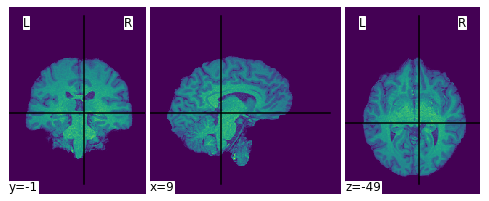

In [4]:
t1w_brain_file_path='/Users/home/Documents/BIDS/sub-0001/ses-001/anat/sub-0001_ses-001_run-01_T1w_brain.nii.gz'

plotting.plot_img(t1w_brain_file_path)

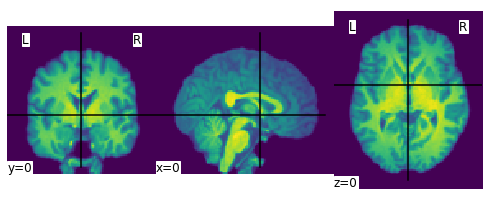

In [5]:
t1w_prepro_file_path='/Users/home/Documents/BIDS/sub-0001/ses-001/run-1.feat/reg/highres2standard.nii.gz'

cut_coords=(0, 0, 0)
plotting.plot_img(t1w_prepro_file_path, cut_coords)

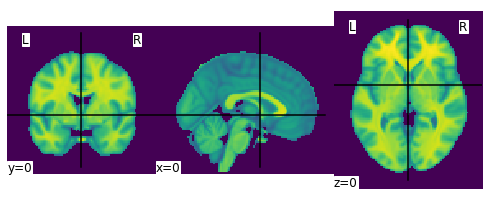

In [6]:
# (0,0,0) no standard MNI (mas tb em Talairach) aponta sempre para uma estrutura anatómica chamada de comissura anterior.
plotting.plot_img(datasets.MNI152_FILE_PATH, cut_coords)

# Functional data.
## Check preprocessing using FSL FEAT

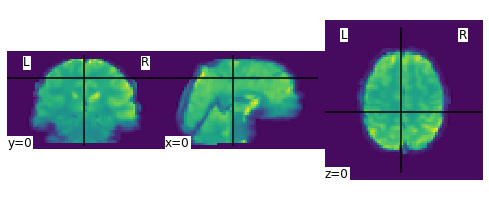

In [7]:
func_data_preproc='/Users/home/Documents/BIDS/sub-0001/ses-001/run-1.feat/filtered_func_data.nii.gz'

mean_fmri_img=mean_img(func_data_preproc)
plotting.plot_img(mean_fmri_img, cut_coords)

(91, 109, 91)


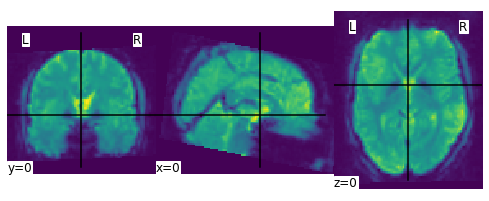

In [8]:
func_data_preproc_2high='/Users/home/Documents/BIDS/sub-0001/ses-001/run-1.feat/reg/example_func2standard.nii.gz'

mean_fmri_img_2high=mean_img(func_data_preproc_2high)

print(image.load_img(func_data_preproc_2high).shape)

plotting.plot_img(mean_fmri_img_2high, cut_coords)

(91, 109, 91, 222)


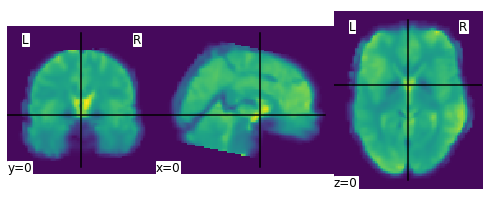

In [9]:
func_data_preproc2standard='/Users/home/Documents/BIDS/sub-0001/ses-001/run-1.feat/filtered_func_data2standard.nii.gz'
print(image.load_img(func_data_preproc2standard).shape)

mean_fmri_img_2standard=mean_img(func_data_preproc2standard)
plotting.plot_img(mean_fmri_img_2standard, cut_coords)

## Look at the events and design matrix.

In [10]:
from nilearn.glm.first_level import make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix

tr = 2.5  # repetition time is ? second
n_scans = 222  # the acquisition comprises ?? scans
frame_times = np.arange(n_scans) * tr  # here are the correspoding frame times

# load events.tsv
events_PATH='/Users/home/Documents/GitHub/MVPA-speech_project/convert-bids-admin/events.tsv'

events_df = pd.read_csv(events_PATH, sep='\t', na_values="n/a")
print(events_df.head())



  trial_type  onset  duration
0  Baseline     0.0      12.5
1      Task    15.0      27.5
2  Baseline    45.0      12.5
3      Task    60.0      27.5
4  Baseline    90.0      12.5


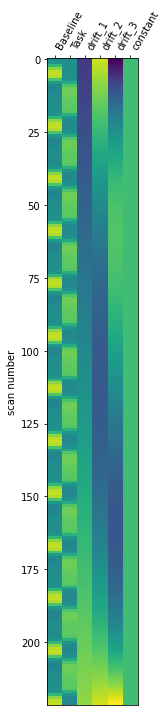

In [11]:
hrf_model='spm'
design_matrix = make_first_level_design_matrix(frame_times, events_df,
                                    drift_model='polynomial', drift_order=3,
                                    hrf_model=hrf_model)

plot_design_matrix(design_matrix)

**Statistical analysis - 1st level**

In [38]:
contrast_matrix = np.eye(design_matrix.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i])
                        for i, column in enumerate(design_matrix.columns)])

In [39]:
basic_contrasts

{'Baseline ': array([1., 0., 0., 0., 0., 0.]),
 'Task ': array([0., 1., 0., 0., 0., 0.]),
 'drift_1': array([0., 0., 1., 0., 0., 0.]),
 'drift_2': array([0., 0., 0., 1., 0., 0.]),
 'drift_3': array([0., 0., 0., 0., 1., 0.]),
 'constant': array([0., 0., 0., 0., 0., 1.])}

In [40]:
from nilearn.glm.first_level import FirstLevelModel

fmri_img='/Users/home/Documents/BIDS/sub-0001/ses-001/func/sub-0001_ses-001_task-fonologico_run-01_bold.nii.gz'

print('Fitting a GLM')
fmri_glm = FirstLevelModel()
fmri_glm = fmri_glm.fit(fmri_img, design_matrices=design_matrix)

Fitting a GLM


In [47]:
mean_image = mean_img(fmri_img)
z_map = fmri_glm.compute_contrast(basic_contrasts['Task '], output_type='z_score')

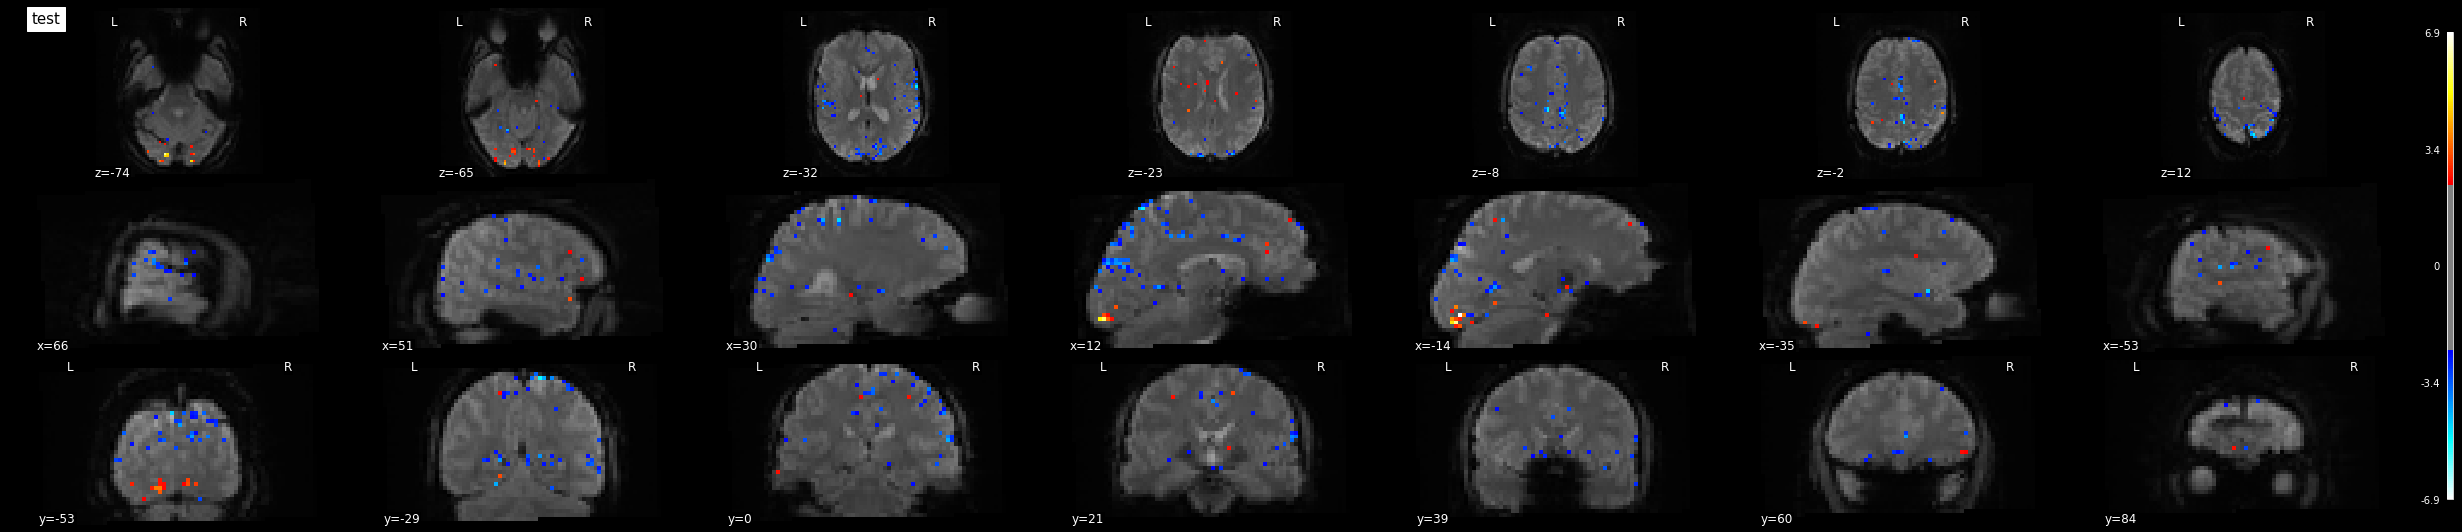

In [49]:
# plot the contrasts 
# the display is overlayed on the mean fMRI image
# a threshold of 3.0 is used, more sophisticated choices are possible
plotting.plot_stat_map(
    z_map, bg_img=mean_image, threshold=2.5, display_mode='mosaic', black_bg=True, title='test')
plotting.show()



/Users/home/.local/lib/python3.8/site-packages/nilearn/surface/surface.py:467: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)


ValueError: The input type is not recognized. Valid inputs are a Numpy array or one of the following file formats: .gii, .gii.gz, .mgz, .nii, .nii.gz, Freesurfer specific files such as .curv, .sulc, .thickness, .annot, .label